# Content <a name="toc"></a>
1. [Reading Data](#p1)
2. [Exploratory Analysis](#p2)
3. [PSI Calculation](#p3)
4. [Feature Selection & Modelling](#p4)
5. [HyperOpt Optimization](#p5)
6. [Model calibration](#p6)
7. [Model report](#p7)

In [17]:
import getpass
import teradatasql
import pandas as pd
import numpy as np


import dill
import pickle
from datetime import datetime
import math
import sys
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostClassifier, Pool, cv
#from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', 1500)
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')
import tqdm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import shap
%pylab inline

import getpass
import teradatasql

from sklearn.metrics import precision_score, recall_score, f1_score
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


# 1. Reading Data <a name="p1"></a>

In [156]:
pswd = getpass.getpass('Enter password:')
connection = teradatasql.connect(None,host='HOST',user='LOGIN',password=pswd)

Enter password:········


In [157]:
start = datetime.now()
print(start)
df = pd.read_sql('select * from DATAMART, connection)
stop = datetime.now()
print(stop)
print("Upload Time: ", stop-start)

2019-12-23 10:45:13.800142
2019-12-23 10:51:11.772980
Upload Time:  0:05:57.972838


In [159]:
df.head()

,visit_month,date_visit_crm,date_report_src_asm,client_id,product_id_crm,dash_product_sale,SELL_TYPE,first_need_group,target,report_dt,client_dk,mdm_id,sd_gender_cd,sd_mdm_status_cd,sd_client_valid_nflag,sd_age_yrs_frac_nv,sd_age_yrs_comp_nv,sd_name_age_segment_cd,sd_stlmnt_type_cd,sd_stlmnt_type2_cd,sd_doc_valid_nflag,sd_doc_type_id,sd_russian_citizen_nflag,sd_resident_nflag,sd_sbrf_employee_nflag,seg_crm_segment_cd,seg_client_ret_segment_cd,seg_crm_client_mgr_login_name,seg_private_banking_nflag,seg_calc_segment_cd,seg_client_segment_cd,seg_client_segment_prev_cd,seg_client_segment_bitmask_cd,seg_crd_txn_mcc_cluster_id,prd_lst_prod_tb_cd,prd_lst_prod_osb_cd,prd_lst_prod_vsp_cd,prd_lst_prod_division_dk,prd_lst_prod_open_dt,prd_lst_prod_close_dt,prd_lst_prod_cd,prd_1st_prod_tb_cd,prd_1st_prod_osb_cd,prd_1st_prod_vsp_cd,prd_1st_prod_division_dk,prd_1st_prod_open_dt,prd_1st_prod_cd,prd_dc_active_nflag,prd_dc_active_qty,prd_dc_active_prev_nflag,prd_dc_activity_ind,prd_cc_active_nflag,prd_cc_active_qty,prd_cc_active_prev_nflag,prd_cc_activity_ind,prd_ma_active_nflag,prd_ma_active_qty,prd_ma_active_prev_nflag,prd_ma_activity_ind,prd_da_active_nflag,prd_da_active_qty,prd_da_active_prev_nflag,prd_da_activity_ind,prd_sc_active_nflag,prd_sc_active_qty,prd_sc_active_prev_nflag,prd_sc_activity_ind,prd_pl_active_nflag,prd_pl_active_qty,prd_pl_active_prev_nflag,prd_pl_activity_ind,prd_mg_active_nflag,prd_mg_active_qty,prd_mg_active_prev_nflag,prd_mg_activity_ind,prd_ib_active_nflag,prd_ib_active_qty,prd_ib_active_prev_nflag,prd_ib_activity_ind,prd_mb_active_nflag,prd_mb_active_qty,prd_mb_active_prev_nflag,prd_mb_activity_ind,prd_ap_cell_active_nflag,prd_ap_cell_active_qty,prd_ap_cell_active_prev_nflag,prd_ap_cell_activity_ind,prd_ap_utl_active_nflag,prd_ap_utl_active_qty,prd_ap_utl_active_prev_nflag,prd_ap_utl_activity_ind,prd_ap_tlc_active_nflag,prd_ap_tlc_active_qty,prd_ap_tlc_active_prev_nflag,prd_ap_tlc_activity_ind,prd_ap_loan_active_nflag,prd_ap_loan_active_qty,prd_ap_loan_active_prev_nflag,prd_ap_loan_activity_ind,prd_ap_budg_active_nflag,prd_ap_budg_active_qty,prd_ap_budg_active_prev_nflag,prd_ap_budg_activity_ind,prd_ap_othr_active_nflag,prd_ap_othr_active_qty,prd_ap_othr_active_prev_nflag,prd_ap_othr_activity_ind,prd_ap_cnbx_active_nflag,prd_ap_cnbx_active_qty,prd_ap_cnbx_active_prev_nflag,prd_ap_cnbx_activity_ind,prd_ap_p2p_active_nflag,prd_ap_p2p_active_qty,prd_ap_p2p_active_prev_nflag,prd_ap_p2p_activity_ind,prd_client_active_nflag,prd_client_active_prev_nflag,prd_client_activity_ind,prd_client_active_prod_qty,prd_client_type_final_cd,prd_client_type_final_prev_cd,prd_activity_status_cd,prd_activity_status_prev_cd,lbt_acct_tot_bal_rub_amt,lbt_acct_dep_tot_bal_rub_amt,lbt_acct_dep_ca_bal_rub_amt,lbt_acct_dep_td_bal_rub_amt,lbt_acct_ma_bal_rub_amt,lbt_acct_dc_bal_rub_amt,lbt_pens_plus_bal_rub_amt,lbt_sav_cert_bal_rub_amt,lbt_acct_tot_qty,lbt_acct_dep_tot_qty,lbt_acct_dep_tot_1000_qty,lbt_acct_dep_tot_online_qty,lbt_acct_dep_ca_qty,lbt_acct_dep_td_qty,lbt_acct_ma_qty,lbt_acct_dc_qty,lbt_pens_plus_qty,lbt_pens_plus_social_qty,lbt_pens_plus_1000_qty,lbt_sav_cert_qty,lbt_acct_dep_max_open_dt,lbt_acct_dep_max_close_dt,lbt_acct_max_bal_division_dk,lbt_acct_max_bal_tb_cd,lbt_acct_max_bal_osb_cd,lbt_acct_max_bal_vsp_cd,lbt_inf_total_rub_amt,lbt_inf_total_qty,lbt_inf_payroll_rub_amt,lbt_inf_payroll_qty,lbt_inf_social_rub_amt,lbt_inf_social_qty,lbt_inf_topup_rub_amt,lbt_inf_topup_qty,lbt_inf_new_acct_rub_amt,lbt_inf_new_acct_qty,lbt_inf_intr_cap_rub_amt,lbt_inf_intr_cap_qty,lbt_inf_othr_rub_amt,lbt_inf_othr_qty,lbt_otf_total_rub_amt,lbt_otf_total_qty,lbt_otf_wthdr_rub_amt,lbt_otf_wthdr_qty,lbt_otf_acct_clsr_rub_amt,lbt_otf_acct_clsr_qty,lbt_otf_intr_pmt_rub_amt,lbt_otf_intr_pmt_qty,lbt_otf_othr_rub_amt,lbt_otf_othr_qty,lbt_payroll_l3m_tot_rub_amt,lbt_payroll_l6m_tot_rub_amt,lbt_payroll_l3m_avg_rub_amt,lbt_payroll_l6m_avg_rub_amt,lbt_payroll_avg_risk_rub_amt,lbt_payroll_min_dt,lbt_payroll_max_dt,lbt_social_l3m_tot_rub_amt,lbt_social_l6m_to

In [170]:
df.shape

(130814, 691)

# 2. Exploratory Analysis <a name="p2"></a>

In [160]:
#Transform "visit_month" from type 'string' to 'date'
df['report_date'] = pd.to_datetime(df['visit_month'])

In [161]:
# Drop all ID's to avoid data leakage and overfitting
droplist = df.filter(regex='id_|_dt|tb_cd|cmpn_sms|cmpn_householder_VIP_nflag|cmpn_sms_tz_msk_shift|cmpn_client_eligible_nflag|ext_client_|client_id|cmpn_email_name|crd_dc_lst_plastic_type_name|cmpn_ctzshp_cntry_name|cmpn_sms_dlvr_time_intr_name|sd_doc_type_name|visit_month|tax_payer|date_visit_crm|_nbr|cmpn_sms_city_name|cmpn_nflag_cbc_stop_list_nflag|division_dk|osb_cd|vsp_cd|cmpn_doc_unique_nflag|cluster_name|cluster_id|orphan|bitmask|mdm_id|client_dk|sd_doc_type_id|seg_crm_client_mgr_login_name').columns
droplist.tolist()

['visit_month',
 'date_visit_crm',
 'client_id',
 'product_id_crm',
 'report_dt',
 'client_dk',
 'mdm_id',
 'sd_client_valid_nflag',
 'sd_doc_valid_nflag',
 'sd_doc_type_id',
 'seg_crm_client_mgr_login_name',
 'seg_client_segment_bitmask_cd',
 'seg_crd_txn_mcc_cluster_id',
 'prd_lst_prod_tb_cd',
 'prd_lst_prod_osb_cd',
 'prd_lst_prod_vsp_cd',
 'prd_lst_prod_division_dk',
 'prd_lst_prod_open_dt',
 'prd_lst_prod_close_dt',
 'prd_1st_prod_tb_cd',
 'prd_1st_prod_osb_cd',
 'prd_1st_prod_vsp_cd',
 'prd_1st_prod_division_dk',
 'prd_1st_prod_open_dt',
 'lbt_acct_dep_max_open_dt',
 'lbt_acct_dep_max_close_dt',
 'lbt_acct_max_bal_division_dk',
 'lbt_acct_max_bal_tb_cd',
 'lbt_acct_max_bal_osb_cd',
 'lbt_acct_max_bal_vsp_cd',
 'lbt_payroll_min_dt',
 'lbt_payroll_max_dt',
 'lbt_social_bitmask_l12m_cd',
 'lbt_social_min_dt',
 'lbt_social_max_dt',
 'lbt_acc_1st_open_dt',
 'lbt_acc_lst_open_dt',
 'lbt_acc_lst_close_dt',
 'lbt_sav_cert_last_purch_dt',
 'lbt_acct_lst_division_dk',
 'lbt_acct_1st_division_dk',
 'crd_dc_payroll_min_open_dt',
 'crd_dc_social_min_open_dt',
 'crd_dc_payroll_act_min_open_dt',
 'crd_dc_social_act_min_open_dt',
 'crd_dc_max_open_dt',
 'crd_cc_max_issue_dt',
 'crd_cc_max_close_dt',
 'crd_lst_agrmnt_tb_cd',
 'crd_lst_agrmnt_osb_cd',
 'crd_lst_agrmnt_vsp_cd',
 'cred_max_open_dt',
 'cred_max_close_dt',
 'srv_thanks_dt',
 'srv_mb_1st_txn_dt',
 'srv_mb_lst_txn_dt',
 'srv_mb_1st_txn_ever_dt',
 'srv_mb_lst_txn_ever_dt',
 'srv_ap_cell_1st_txn_dt',
 'srv_ap_cell_lst_txn_dt',
 'srv_ap_cell_1st_txn_ever_dt',
 'srv_ap_cell_lst_txn_ever_dt',
 'srv_ap_utl_1st_txn_dt',
 'srv_ap_utl_lst_txn_dt',
 'srv_ap_utl_1st_txn_ever_dt',
 'srv_ap_utl_lst_txn_ever_dt',
 'srv_ap_tlc_1st_txn_dt',
 'srv_ap_tlc_lst_txn_dt',
 'srv_ap_tlc_1st_txn_ever_dt',
 'srv_ap_tlc_lst_txn_ever_dt',
 'srv_ap_loan_1st_txn_dt',
 'srv_ap_loan_lst_txn_dt',
 'srv_ap_loan_1st_txn_ever_dt',
 'srv_ap_loan_lst_txn_ever_dt',
 'srv_ap_budg_1st_txn_dt',
 'srv_ap_budg_lst_txn_dt',
 'srv_ap_budg_1st_txn_ever_dt',
 'srv_ap_budg_lst_txn_ever_dt',
 'srv_ap_othr_1st_txn_dt',
 'srv_ap_othr_lst_txn_dt',
 'srv_ap_othr_1st_txn_ever_dt',
 'srv_ap_othr_lst_txn_ever_dt',
 'srv_ap_cnbx_1st_txn_dt',
 'srv_ap_cnbx_lst_txn_dt',
 'srv_ap_cnbx_1st_ever_dt',
 'srv_ap_cnbx_lst_ever_dt',
 'srv_ap_p2p_1st_txn_dt',
 'srv_ap_p2p_lst_txn_dt',
 'srv_ap_p2p_1st_txn_ever_dt',
 'srv_ap_p2p_lst_txn_ever_dt',
 'srv_sbol_1st_login_dt',
 'srv_sbol_lst_login_dt',
 'srv_sbol_1st_login_ever_dt',
 'srv_sbol_lst_login_ever_dt',
 'srv_sbol_1st_txn_dt',
 'srv_sbol_lst_txn_dt',
 'srv_sbol_1st_txn_ever_dt',
 'srv_sbol_lst_txn_ever_dt',
 'srv_sbol_atm_lst_login_dt',
 'srv_sbol_web_lst_login_dt',
 'srv_sbol_mob_lst_login_dt',
 'srv_sbol_atm_lst_login_ever_dt',
 'srv_sbol_web_lst_login_ever_dt',
 'srv_sbol_mob_lst_login_ever_dt',
 'srv_udbo_open_dt',
 'ext_client_app_income_amt',
 'ext_stop_list_dt',
 'tp_1st_open_dt',
 'tp_lst_open_dt',
 'tp_lst_grace_end_exp_dt',
 'tp_lst_close_dt',
 'tp_lst_tb_cd',
 'tp_lst_division_dk',
 'lne_tot_min_open_dt',
 'lne_tot_max_open_dt',
 'lne_tot_max_close_dt',
 'lne_tot_max_exp_dt',
 'lne_pl_min_open_dt',
 'lne_pl_max_open_dt',
 'lne_pl_max_close_dt',
 'lne_pl_max_exp_dt',
 'lne_mg_min_open_dt',
 'lne_mg_max_open_dt',
 'lne_mg_max_close_dt',
 'lne_mg_max_exp_dt',
 'lbt_payroll_tax_payer_cd',
 'srv_sbol_atm_1st_login_ever_dt',
 'srv_sbol_web_1st_login_ever_dt',
 'srv_sbol_mob_1st_login_ever_dt',
 'sd_doc_type_name',
 'seg_crd_txn_mcc_cluster_name',
 'cla_all_active_last_dt',
 'cla_crd_dc_active_last_dt',
 'cla_crd_cc_active_last_dt',
 'cla_mb_active_last_dt',
 'cla_pay_active_last_dt',
 'cla_p2p_active_last_dt',
 'cla_da_active_last_dt',
 'cla_sc_active_last_dt',
 'cla_ma_active_last_dt',
 'cla_pl_active_last_dt',
 'cla_mg_active_last_dt',
 'cla_inv_mf_active_last_dt',
 'cla_inv_tm_active_last_dt',
 'cla_inv_bo_active_last_dt',
 'prd_lst_prod_open_dtdm',
 'lne_pl_max_open_dtdm',
 'lne_pl_max_exp_dtdm',
 'cla_all_active_last_dt_mnths',
 'cla_mb_active_last_dt_mnths',
 'orphan',
 'report_dt

In [162]:
df.drop(columns=droplist, axis=1, inplace=True)

In [163]:
#Feature Exploratory Analysis
def calc_stats_df(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], 
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 
                                                 'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=False,inplace=True)
    return stats_df

In [164]:
stats_df_train=calc_stats_df(df)
stats_df_train

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
307,crd_cc_pos_othr_rub_amt,0,100.0,100.000000,object
306,crd_cc_pos_othr_qty,0,100.0,100.000000,object
737,crd_pos_othr_3m_amt,0,100.0,100.000000,object
736,crd_pos_othr_3m_qty,0,100.0,100.000000,object
654,row_insert_ts,0,100.0,100.000000,object
...,...,...,...,...,...
1,dash_product_sale,1,0.0,100.000000,object
4,target,2,0.0,91.309034,int64
3,first_need_group,1,0.0,100.000000,object
2,SELL_TYPE,1,0.0,100.000000,object


In [165]:
df.drop(stats_df_train[stats_df_train['Unique_values']<=1]['Feature'].values,axis=1,inplace=True)
stats_df_train=stats_df_train[stats_df_train['Unique_values']>1]
stats_df_train.type.value_counts()

float64           844
object             42
datetime64[ns]      1
int64               1
Name: type, dtype: int64

### Encoding

In [168]:
# Find and exclude features having more than 95% 'missing' values
 
X_is_na = df.isna().sum()/df.shape[0]
X_is_na = X_is_na[X_is_na>0.95].sort_values()
list_of_index_bad_nan = X_is_na.index.to_list()
df.drop(list_of_index_bad_nan, axis=1, inplace=True)

In [171]:
df.shape

(130814, 691)

### Split our dataset for Modelling and Out-ouf-Time for performance check

In [172]:
# Разделяем выборку на основную и отложенную 

oot = df[(df['report_date'] == '2019-11-30')]
df = df[(df['report_date'] != '2019-11-30')]

In [173]:
print('Shape of TRAIN dataset: ', df.shape)
print('Shape of Out-of-Time dataset: ', oot.shape)

Shape of TRAIN dataset:  (102656, 691)
Shape of Out-of-Time dataset:  (28158, 691)


In [76]:
del df['report_date']
del oot['report_date']

In [174]:

object_feature = df.dtypes[df.dtypes==object].index.to_list() 
df[object_feature] = df[object_feature].fillna('nan')

In [175]:
class MyEncoder:
    
    def __init__(self, name):
        self.name = name
        self.columns = None
        self.dict = {}
    
    def fit(self, X, list_to_encode):
        self.columns = list_to_encode
        for column in list_to_encode:
            self.dict[column] = LabelEncoder().fit(X[column].astype(str))
            
    def transform(self, X):
        for column in self.columns:
            X[column] = self.dict[column].transform(X[column].astype(str))
            
    def fit_transform(self, X, list_to_encode: list):
        self.fit(X, list_to_encode)
        self.transform(X)

In [176]:
enc = MyEncoder('encoder')
enc.fit(df, object_feature)
enc.transform(df)

In [177]:
# Save our trained Encoder
pkl_filename = "Encode_LIFEINS_CC_v1.0.dill"
with open (pkl_filename, 'wb') as file:
    dill.dump(enc,file)

In [178]:
# Transform our Out-of-Sample dataset
oot[object_feature] = oot[object_feature].fillna('nan')
enc.transform(oot)

**X, y**

In [179]:
X = df.drop(['target'], axis=1)
y = df.target

In [180]:
print('Labels:{}'.format(set(y)))
print('Zero count = {}. One count = {}'.format(len(y)-sum(y), sum(y)))

Labels:{0, 1}
Zero count = 93792. One count = 8864


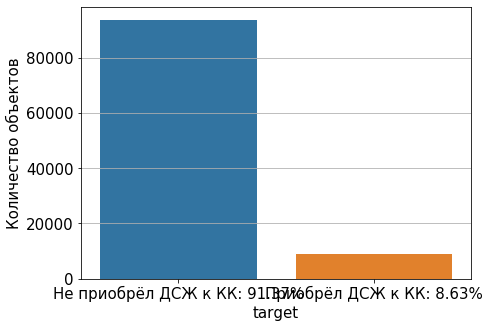

In [183]:
plt.figure(figsize=(7,5))
plt.grid()
sns.countplot(y)
plt.xticks((0,1), ['Did not acquired a product X: {:.2%}'.format(y.value_counts()[0]/y.value_counts().sum()),
                   'Acquired a product X: {:.2%}'.format(y.value_counts()[1]/y.value_counts().sum())])
plt.ylabel('Amount of clients')
plt.show()

In [184]:
# Split our dataset on train data and target
X_oot = oot.drop(['target'], axis=1)
y_oot = oot.target

In [185]:
print('Target categories:{}'.format(set(y_oot)))
print('Amount 0 = {}. Amount 1 = {}'.format(len(y_oot)-sum(y_oot), sum(y_oot)))

Категории таргета:{0, 1}
Кол-во 0 = 25653. Кол-во 1 = 2505


# 3. PSI Calculation <a name="p3"></a>

In [186]:
def usr_al_psi(dts1, dts2, n_groups):
    dts1_prc = []
    dts2_prc = []
    psi = []
    null_cat = 'N'
    if len(dts1[~dts1.notnull()]) * len(dts2[~dts2.notnull()]) > 0:
        psi_null = (len(dts1[~dts1.notnull()]) / len(dts1) - len(dts2[~dts2.notnull()]) / len(dts2)) * \
            math.log((len(dts1[~dts1.notnull()]) / len(dts1))/(len(dts2[~dts2.notnull()]) / len(dts2)))
    elif len(dts1[~dts1.notnull()]) + len(dts1[~dts1.notnull()]) == 0:
        psi_null = 0
    else:
        psi_null = 1
        if len(dts1[~dts1.notnull()]) > 0:
            null_cat = 'T'
        else:
            null_cat = 'V'
    dts1 = dts1[dts1.notnull()]
    dts2 = dts2[dts2.notnull()]
    dts1 = dts1.tolist()
    dts2 = dts2.tolist()
    dts1.sort()
    psi_group = set(dts1[int(i * len(dts1) / n_groups)] for i in range(1, n_groups))
    psi_group = list(psi_group)
    psi_group.sort()
    psi_txt_group=[]
    j = 0
    while j < len(psi_group):
        if j == 0:
            dts1_prc.append(len([dts1[i] for i in range(0, len(dts1)) if dts1[i] <= psi_group[j]])/len(dts1))
            dts2_prc.append(len([dts2[i] for i in range(0, len(dts2)) if dts2[i] <= psi_group[j]])/len(dts2))
            psi_txt_group.append('X <= ' + str(psi_group[j]))
        else:
            dts1_prc.append(len([dts1[i] for i in range(0, len(dts1)) if dts1[i] <= psi_group[j] and dts1[i] > psi_group[j - 1]])/len(dts1))
            dts2_prc.append(len([dts2[i] for i in range(0, len(dts2)) if dts2[i] <= psi_group[j] and dts2[i] > psi_group[j - 1]])/len(dts2))
            psi_txt_group.append(str(psi_group[j - 1]) + ' < X <= ' + str(psi_group[j]))
        if j == len(psi_group) - 1:
            dts1_prc.append(len([dts1[i] for i in range(0, len(dts1)) if dts1[i] > psi_group[j]])/len(dts1))
            dts2_prc.append(len([dts2[i] for i in range(0, len(dts2)) if dts2[i] > psi_group[j]])/len(dts2))
            psi_txt_group.append('X > ' + str(psi_group[j]))
        j += 1
    psi_df = pd.DataFrame(psi_txt_group, columns=['group']).join(pd.DataFrame(dts1_prc, columns=['dts1_prc'])).join(pd.DataFrame(dts2_prc, columns=['dts2_prc']))
    psi_df['psi'] = 0
    psi_df['psi'] [psi_df.dts1_prc != psi_df.dts2_prc] = (psi_df.dts1_prc - psi_df.dts2_prc) * ((psi_df.dts1_prc+0.00001) / psi_df.dts2_prc).apply(math.log)
    return sum(psi_df.psi) + psi_null, ''
    #if psi_null != 1:
    #    return sum(psi_df.psi) + psi_null, ''
    #else:
    #    return "%.8f" % sum(psi_df.psi), 'Non-matching NaN is found. (' + null_cat + ') PSI -> without NaN'

def psi_df(df1, df2, path):
    psi_cat = []
    psi_df = pd.DataFrame(columns=['Variable','PSI', 'Comment'])
    j = 0
    for i in df1.columns.tolist():
        if ('int' in str(df1[df1[i].notnull()][i].dtype) or 'float' in str(df1[df1[i].notnull()][i].dtype)) and (df1[i].unique().shape[0] > 3 or (df1[i].unique().shape[0] > 2 and not (df1[i].isnull().values.any()))):
            if type(usr_al_psi(df1[i], df2[i].astype(float), 10)) != str:
                psi_df.loc[j] = [i, "%.8f" % float(usr_al_psi(df1[i], df2[i].astype(float), 10)[0]), usr_al_psi(df1[i], df2[i].astype(float), 10)[1]]
#                 print(i, ': ', "%.8f" % usr_al_psi(df1[i], df2[i].astype(float), 10))
            else:
                psi_df.loc[j] = [i, float(usr_al_psi(df1[i], df2[i].astype(float), 10)[0]), usr_al_psi(df1[i], df2[i].astype(float), 10)[1]]
#                 print(i, ': ', usr_al_psi(df1[i], df2[i].astype(float), 10))
        else:
            df1[i] = df1[i].astype(str)
            df2[i] = df2[i].astype(str)
            df1[i].fillna('MISSING', inplace=True)
            df2[i].fillna('MISSING', inplace=True)
            if sorted(df1[i].unique().tolist()) == sorted(df2[i].unique().tolist()):
                for cat in df1[i].unique():
                    ben_pct = (df1[df1[i]==cat][i].count() +0.0) / df1.shape[0]
                    comp_pct = (df2[df2[i]==cat][i].count() +0.0) / df2.shape[0]
                    psi_cat.append((ben_pct-comp_pct)*math.log(ben_pct/comp_pct))                
                psi=sum(psi_cat)
                psi_df.loc[j] = [i, "%.8f" % psi, '']
#                 print(i, ': ', "%.8f" % psi)
            else:
                psi=sum(psi_cat)
                psi_df.loc[j] = [i, "%.8f" % psi, 'Non-matching categories are found: ' + \
                      str([set(df1[i].unique()) - set(df2[i].unique()), set(df2[i].unique()) - set(df1[i].unique())]) + \
                        ' PSI -> only common categories']
#                 print(i, ': ', 'Non-mathcing categories are found: ', end = '')
#                 print([set(df1[i].unique()) - set(df2[i].unique()), set(df2[i].unique()) - set(df1[i].unique())], end = ' ')
#                 print('PSI(only common categories): ', "%.8f" % psi)
        j += 1
    if path != '':
        psi_df.to_csv(path, index=None)
    return psi_df

def action_with_warnings():
    warnings.warn("should not appear")

In [187]:
# Split dataset on Train and Out-of-Sample test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [188]:
# Split dataset on Train and Validation sets
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train,y_train,test_size=0.3, random_state=1)

In [189]:
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test.shape)
print(X_oot.shape)
print(y_train.sum())
print(y_oot.sum())

(57486, 690)
(24638, 690)
(20532, 690)
(28158, 690)
7135
2505


In [190]:
PSIall_1 = pd.DataFrame({'Feature': [], 'PSI': []})
topPSIall_1 = []

for i in X_train.columns:
    print(i)
    a = usr_al_psi(X_train[i], X_oot[i], 20)
    print(a)
    if (a[0] < 0.1): 
        topPSIall_1 = np.append(topPSIall_1, i)
    PSIfeat = pd.DataFrame({'Feature': [i], 'PSI': [a[0]]})
    PSIall_1 = pd.concat([PSIall_1, PSIfeat])
    print()

sd_gender_cd
(2.064254980936501e-05, '')

sd_mdm_status_cd
(1.1883376168061841e-06, '')

sd_age_yrs_frac_nv
(0.009652849769775573, '')

sd_age_yrs_comp_nv
(0.010238747390402102, '')

sd_name_age_segment_cd
(0.0062431964968337, '')

sd_stlmnt_type_cd
(0.0082044601019212, '')

sd_stlmnt_type2_cd
(0.0122587964439621, '')

sd_russian_citizen_nflag
(1.368710321957237e-06, '')

sd_resident_nflag
(1.368710321957237e-06, '')

sd_sbrf_employee_nflag
(0.00013569400973615766, '')

seg_client_ret_segment_cd
(0.005195472431644227, '')

seg_client_segment_cd
(0.006374120514518226, '')

seg_client_segment_prev_cd
(0.0067863610856039504, '')

prd_lst_prod_cd
(0.005357362139878869, '')

prd_1st_prod_cd
(0.002177921824822466, '')

prd_dc_active_nflag
(2.545236501245524e-05, '')

prd_dc_active_qty
(0.000602710026930454, '')

prd_dc_active_prev_nflag
(5.3981968435276904e-06, '')

prd_dc_activity_ind
(0.5168666532359869, '')

prd_cc_active_nflag
(4.259850805930038e-05, '')

prd_cc_active_qty
(4.29626015868

(0.002633397747854201, '')

crd_inf_transfer_qty
(0.0029358151861888673, '')

crd_inf_pos_ret_rub_amt
(0.006903623407039146, '')

crd_inf_pos_ret_qty
(0.006538474491093767, '')

crd_inf_othr_rub_amt
(0.0014453909241475401, '')

crd_inf_othr_qty
(0.0014453909241475401, '')

crd_otf_total_rub_amt
(0.010146615760181905, '')

crd_otf_dc_total_rub_amt
(0.010104676371996121, '')

crd_otf_total_qty
(0.0057457062190813864, '')

crd_otf_dc_total_qty
(0.005799411522793356, '')

crd_otf_pos_spend_rub_amt
(0.00885111477200947, '')

crd_otf_dc_pos_spend_rub_amt
(0.009043272694165291, '')

crd_otf_pos_spend_qty
(0.011111511036269719, '')

crd_otf_dc_pos_spend_qty
(0.011303955172892547, '')

crd_otf_fee_rub_amt
(0.006823013223926427, '')

crd_otf_fee_qty
(0.006093155582304877, '')

crd_otf_cash_rub_amt
(0.007122803848765396, '')

crd_otf_dc_cash_rub_amt
(0.007373937210031415, '')

crd_otf_cash_qty
(0.010259774421554246, '')

crd_otf_dc_cash_qty
(0.010302635070154291, '')

crd_otf_cash_sb_rub_amt
(0.0

(0.006041875811330443, '')

lne_tot_max_ovrd_open_days
(0.0026690414345883215, '')

lne_tot_max_ovrd_ever_days
(0.0009951124912617557, '')

lne_tot_max_ovrd_open_rub_amt
(0.00219739498238811, '')

lne_tot_max_ovrd_ever_rub_amt
(0.0016573210103333763, '')

lne_tot_dq_entr_ever_qty
(0.0010889095370749764, '')

lne_tot_open_wavg_intr_rate
(0.021929309790655688, '')

lne_pl_agr_open_qty
(0.013074608800812997, '')

lne_pl_agr_os_qty
(0.012216263390570218, '')

lne_pl_agr_open_ever_qty
(0.0017694929724823452, '')

lne_pl_agr_clsd_ever_qty
(0.010023345950290868, '')

lne_pl_agr_clsd_00_ever_qty
(0.006046237153403409, '')

lne_pl_debt_due_rub_amt
(0.017435396744957598, '')

lne_pl_debt_ovrd_rub_amt
(0.0006652410042791415, '')

lne_pl_debt_os_rub_amt
(0.018036018600124742, '')

lne_pl_issued_open_rub_amt
(0.014842843209929468, '')

lne_pl_issued_ever_rub_amt
(0.006050850567257443, '')

lne_pl_max_ovrd_open_days
(0.0019360979817148625, '')

lne_pl_max_ovrd_ever_days
(0.0018900751029404966, '')



(1.3797609267091251e-05, '')

lifestyle_buycar
(1.3797609267091251e-05, '')

lifestyle_mobileos
(0.0019959923948944603, '')

profession_ip
(0.0003825397981817745, '')

lifestyle_wealth_upgrade
(0.0010162587930262932, '')

lifestyle_higher_segment
(0.0008295648902536255, '')

lifestyle_good_driver
(3.921829578693838e-05, '')

prgnt_salary_paym_amt_rub
(7.258682953118284e-05, '')

prgnt_other_paym_qty
(0.0006946192606267072, '')

prgnt_other_paym_amt_rub
(0.0006946192606267072, '')

lifestyle_estate_owner
(0.0009034161417395156, '')

opinion_leader
(0.0002654181645077055, '')

lifestyle_gamer
(0.004092980586502441, '')

trans_abroad
(1.396148237686761e-06, '')

other_bank_credit
(4.633429396586388e-05, '')

potential_tax_segment
(1.5374393642038126e-06, '')

sad_event
(2.09669035633121e-06, '')

lifestyle_investor
(3.690634039716204e-05, '')

cmpn_tm_avail_nflag
(0.012847845425157533, '')

cmpn_dm_avail_nflag
(0.028095104954439024, '')

cmpn_email_avail_nflag
(0.012514154957211225, '')



(0.0056273406984482886, '')

dep_td_open_qty
(0.0041192034823647455, '')

dep_td_open_bal_rub_amt
(0.006661407190555178, '')

seg_prd_uko_avail_nflag
(0.02525579473145526, '')

seg_prd_ap_avail_nflag
(0.02757251671438869, '')

seg_prd_mb_otd_avail_nflag
(0.013603231930188668, '')

seg_prd_mb_own_avail_nflag
(0.01365696869149575, '')

seg_prd_mb_p2p_avail_nflag
(0.012868978739319286, '')

seg_prd_sbol_mob_avail_nflag
(0.012633280743645016, '')

seg_prd_sbol_web_avail_nflag
(0.013118242745974585, '')

cmpn_true_stop_list_nflag
(0.02111164542761592, '')

cmpn_potential_vip_nflag
(0.012915095450880662, '')

seg_prd_sbol_tip_avail_nflag
(0.012596951148726361, '')

cmpn_cross_chnl_clnt_nflag
(0.012801539708303776, '')

cmpn_public_person_nflag
(0.012529101847027421, '')

cmpn_blogger_nflag
(inf, '')

cmpn_mdm_sms_avail_nflag
(0.012827769643969752, '')

cmpn_mdm_cell_phone_mbk_nflag
(0.014699885270318534, '')

cmpn_tpin_avail_nflag
(0.01257025000742633, '')

seg_prd_smart_avail_nflag
(0.01937

In [195]:
print('Feature amount which are stable on (train) and Out-of-Time (OOT) datasets: {}'.format(len(topPSIall_1)))

Кол-во фичей, которые стабильны по PSI на обучающей (train) и Out-of-Time (OOT) выборках: 613


In [194]:
PSIall_1.to_csv('PSI_dep_all.csv')

In [196]:

categorical_feature = []

for i in topPSIall_1:
    if i in object_feature: 
        categorical_feature = np.append(categorical_feature, i)

In [197]:
categorical_feature

array(['sd_gender_cd', 'sd_mdm_status_cd', 'sd_name_age_segment_cd',
       'sd_stlmnt_type_cd', 'sd_stlmnt_type2_cd',
       'seg_client_ret_segment_cd', 'seg_client_segment_cd',
       'seg_client_segment_prev_cd', 'prd_lst_prod_cd', 'prd_1st_prod_cd',
       'prd_client_type_final_cd', 'prd_client_type_final_prev_cd',
       'prd_activity_status_cd', 'prd_activity_status_prev_cd',
       'cred_cred_hist_cd', 'prd_activity_status_1m_cd',
       'prd_activity_status_prev_1m_cd', 'seg_service_channel_cd',
       'prd_lst_prod_tb_name', 'prd_1st_prod_tb_name',
       'sd_name_age_segment2_cd', 'prd_city_lst_prod',
       'lifestyle_travel_class', 'lifestyle_mobileos',
       'potential_tax_segment', 'crd_dc_lst_ips_cd', 'cmpn_email_src_cd',
       'seg_crd_segm_special_cd', 'seg_crd_segm_special_prev_cd',
       'seg_premier_cd', 'cmpn_seg_crd_pos_cat_group',
       'cmpn_seg_crd_trx_segm', 'cmpn_seg_crd_trx_subsegm',
       'cmpn_seg_client_ret_segment_cd'], dtype='<U32')

# 4. Feature Selection & Modelling <a name="p4"></a>

In [1]:
# Build models with different random_seeds on all stable features ( list "topPSIall_1") and look at Feature Importance metric


In [198]:
X_train = X_train[topPSIall_1].fillna(-999)
X_test = X_test[topPSIall_1].fillna(-999)
X_oot = X_oot[topPSIall_1].fillna(-999)

In [200]:
FI_all = pd.DataFrame({'Features': X_train.columns.tolist()})
random_state_ = [0, 17, 42, 76, 98, 123, 151, 169, 183, 241]

model = LGBMClassifier(random_state=1,
                      n_estimators = 100,
                      depth=6, 
                      learning_rate= 0.14)

for k in random_state_:
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train[topPSIall_1], y_train, test_size=0.2, random_state=k)
    model.fit(X_train_1, y_train_1)
    
    #shap values
    explainer=shap.TreeExplainer(model)
    shap_values=explainer.shap_values(X_test_1)
    
    vals = np.abs(shap_values).mean(0)
   
    feature_imp = pd.DataFrame(list(zip(X_train_1.columns, vals)), columns = ['col_name', 'important_value'])

    shap_val = feature_imp['important_value'].mean(axis=0)
    cols = X_train_1.columns.tolist()
    
    # create dataframe
    FI = pd.DataFrame({'Features': X_train_1.columns.tolist(), str(k): shap_val})
    FI_all=pd.concat([FI_all, FI[str(k)]], axis=1)
    print('random_state ' + str(k))

random_state 0
random_state 17
random_state 42
random_state 76
random_state 98
random_state 123
random_state 151
random_state 169
random_state 183
random_state 241


In [201]:
FI_all.head()

,Features,0,17,42,76,98,123,151,169,183,241
0,sd_gender_cd,0.021999,0.015728,0.006468,0.008779,0.022475,0.013723,0.015537,0.029667,0.014630,0.015818
1,sd_mdm_status_cd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,sd_age_yrs_frac_nv,0.104579,0.123805,0.147471,0.104052,0.118785,0.153595,0.171611,0.160646,0.139140,0.128728
3,sd_age_yrs_comp_nv,0.099498,0.038178,0.085593,0.062523,0.041887,0.075315,0.028759,0.111055,0.054597,0.058375
4,sd_name_age_segment_cd,0.000000,0.000000,0.000000,0.009478,0.002014,0.000124,0.000197,0.000000,0.001181,0.000000


In [202]:
FI_all['FI']=FI_all[['0','17','42','76','98','123', '151', '169', '183', '241']].mean(axis=1)

Text(0.5, 0, 'Importance')

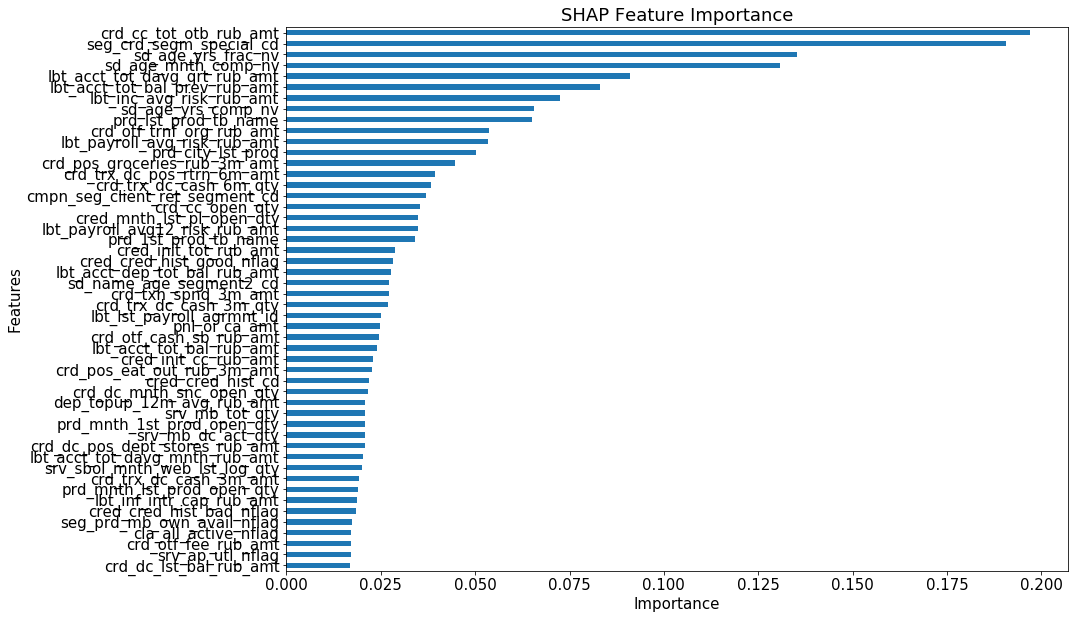

In [203]:
fea_imp=pd.DataFrame({'Importance': FI_all['FI'].tolist(), 'Features': FI_all['Features'].tolist()})
fea_imp=fea_imp.sort_values(['Importance', 'Features'], ascending=[True,False]).iloc[-50:]
fea_imp.plot(kind='barh', x='Features', y='Importance', figsize=(14,10), legend=None)
plt.title('SHAP Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

**Split shap_features**

In [211]:
split_shap_features = FI_all[['Features','FI']].sort_values('FI', ascending=False)[:100]['Features'].tolist()
split_shap_features

['crd_cc_tot_otb_rub_amt',
 'seg_crd_segm_special_cd',
 'sd_age_yrs_frac_nv',
 'sd_age_mnth_comp_nv',
 'lbt_acct_tot_davg_qrt_rub_amt',
 'lbt_acct_tot_bal_prev_rub_amt',
 'lbt_inc_avg_risk_rub_amt',
 'sd_age_yrs_comp_nv',
 'prd_lst_prod_tb_name',
 'crd_otf_trnf_org_rub_amt',
 'lbt_payroll_avg_risk_rub_amt',
 'prd_city_lst_prod',
 'crd_pos_groceries_rub_3m_amt',
 'crd_trx_dc_pos_rtrn_6m_amt',
 'crd_trx_dc_cash_6m_qty',
 'cmpn_seg_client_ret_segment_cd',
 'crd_cc_open_qty',
 'cred_mnth_lst_pl_open_qty',
 'lbt_payroll_avg12_risk_rub_amt',
 'prd_1st_prod_tb_name',
 'cred_init_tot_rub_amt',
 'cred_cred_hist_good_nflag',
 'lbt_acct_dep_tot_bal_rub_amt',
 'sd_name_age_segment2_cd',
 'crd_txn_spnd_3m_amt',
 'crd_trx_dc_cash_3m_qty',
 'lbt_lst_payroll_agrmnt_id',
 'pnl_oi_ca_amt',
 'crd_otf_cash_sb_rub_amt',
 'lbt_acct_tot_bal_rub_amt',
 'cred_init_cc_rub_amt',
 'crd_pos_eat_out_rub_3m_amt',
 'cred_cred_hist_cd',
 'crd_dc_mnth_snc_open_qty',
 'dep_topup_12m_avg_rub_amt',
 'srv_mb_tot_qty',
 'prd_mnth_1st_prod_open_qty',
 'srv_mb_dc_act_qty',
 'crd_dc_pos_dept_stores_rub_amt',
 'lbt_acct_tot_davg_mnth_rub_amt',
 'srv_sbol_mnth_web_lst_log_qty',
 'crd_trx_dc_cash_3m_amt',
 'prd_mnth_lst_prod_open_qty',
 'lbt_inf_intr_cap_rub_amt',
 'cred_cred_hist_bad_nflag',
 'seg_prd_mb_own_avail_nflag',
 'cla_all_active_nflag',
 'crd_otf_fee_rub_amt',
 'srv_ap_utl_nflag',
 'crd_dc_lst_bal_rub_amt',
 'lbt_acct_tot_davg_yr_rub_amt',
 'lne_debt_overdue_bal_rub_amt',
 'sd_gender_cd',
 'pnl_oi_total_amt',
 'lifestyle_mobileos',
 'dep_td_open_bal_rub_amt',
 'seg_prd_smart_avail_nflag',
 'lbt_payroll_l6m_tot_rub_amt',
 'crd_trx_dc_cash_6m_amt',
 'crd_pos_dept_stores_rub_3m_amt',
 'crd_otf_fee_qty',
 'cred_max_pmt_rub_amt',
 'cred_mnth_snc_lst_open_qty',
 'srv_ap_cell_qty',
 'crd_txn_snpd_pos_ever_qty',
 'cmpn_trx_segm_activity_ind',
 'pnl_oi_othr_amt',
 'lbt_inf_total_rub_amt',
 'srv_mb_mnth_lst_txn_qty',
 'crd_cc_mnth_snc_close_qty',
 'crd_otf_trnf_pers_mb_qty',
 'crd_pos_eat_out_3m_qty',
 'prd_lst_prod_cd',
 'sd_stlmnt_type2_cd',
 'lbt_otf_total_rub_amt',
 'srv_sbol_mnth_lst_login_qty',
 'lifestyle_level_no_cash',
 'crd_pos_tourism_rub_3m_amt',
 'lbt_inf_topup_rub_amt',
 'srv_ap_cell_mnth_lst_txn_qty',
 'crd_dc_lst_plastic_type_id',
 'srv_sbol_mnth_lst_txn_qty',
 'lbt_acct_dep_mnth_lst_clsr_qty',
 'lifestyle_lifequality',
 'crd_dc_tot_bal_rub_amt',
 'crd_dc_pos_groceries_rub_amt',
 'crd_inf_ext_transf_rub_amt',
 'crd_otf_trnf_pers_mb_rub_amt',
 'lne_tot_max_ovrd_ever_days',
 'cred_mg_act_initial_rub_amt',
 'lbt_social_avg12_risk_rub_amt',
 'lifestyle_estate_owner',
 'cmpn_cross_chnl_clnt_nflag',
 'seg_crd_segm_special_prev_cd',
 'dep_ca_open_bal_rub_amt',
 'crd_dc_mnth_snc_lst_open_qty',
 'prd_client_active_prod_1m_qty',
 'crd_otf_cash_rub_amt',
 'crd_pos_utilities_rub_3m_amt',
 'dep_topup_12m_qty']

**CatBoost model**

In [212]:
categorical_feature = []

for i in split_shap_features:
    if i in object_feature: 
        categorical_feature = np.append(categorical_feature, i)

In [213]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [214]:
catBoost = CatBoostClassifier(iterations=800,
                         learning_rate= 0.021, #0.16626664163923466,
                         depth=4,
                         scale_pos_weight=10,
                         l2_leaf_reg = 9.922430597641636,
                         custom_loss=['AUC'],
                         random_seed=802,
                         bagging_temperature = 0.2,
#                        od_type='Iter',
                         metric_period=100,
#                         od_wait=100,
                         early_stopping_rounds=50
                             )

catBoost.fit(X_train_1[split_shap_features],y_train_1, cat_features=categorical_feature)

0:	learn: 0.6905856	total: 28.2ms	remaining: 22.5s
100:	learn: 0.6103170	total: 2.43s	remaining: 16.8s
200:	learn: 0.5911714	total: 4.8s	remaining: 14.3s
300:	learn: 0.5812560	total: 7.04s	remaining: 11.7s
400:	learn: 0.5749072	total: 9.26s	remaining: 9.21s
500:	learn: 0.5690828	total: 11.6s	remaining: 6.92s
600:	learn: 0.5622767	total: 13.9s	remaining: 4.61s
700:	learn: 0.5556428	total: 16.3s	remaining: 2.3s
799:	learn: 0.5497754	total: 18.7s	remaining: 0us


In [215]:
# all features
print('Gini Train: {0}'.format(round(-1+2*roc_auc_score(y_train, catBoost.predict_proba(X_train[split_shap_features])[:,1]),4))) 
print('Gini Out-of-Sample Test: {0}'.format(round(-1+2*roc_auc_score(y_test, catBoost.predict_proba(X_test[split_shap_features])[:,1]),4)))
print('Gini Out-of-Time Test: {0}'.format(round(-1+2*roc_auc_score(y_oot, catBoost.predict_proba(X_oot[split_shap_features])[:,1]),4)))

Gini Train: 0.5594
Gini Out-of-Sample Test: 0.5053
Gini Out-of-Time Test: 0.5071


### Feature Selection

In [216]:
gini_score = []
categorical_feature = []
var_200 = []
k=1

for i in split_shap_features: #split_shap_features:
    if i in object_feature:
        categorical_feature = categorical_feature + [i]
    var_200 = np.append(var_200, i)
    catBoost.fit(X_train_1[var_200], y_train_1, cat_features = categorical_feature, verbose=0)
    a = roc_auc_score(y_val_1,catBoost.predict_proba(X_val_1[var_200])[:,1])
    print(str(k)+' '+i+' -> ROC AUC: {0} _//////_ GINI: {1}'.format(
        round(a,4),
        round(-1+2*a,4)))
    print('')
    k+=1
    gini_score.append(-1+2*a)

1 crd_cc_tot_otb_rub_amt -> ROC AUC: 0.5681 _//////_ GINI: 0.1362

2 seg_crd_segm_special_cd -> ROC AUC: 0.6278 _//////_ GINI: 0.2555

3 sd_age_yrs_frac_nv -> ROC AUC: 0.6775 _//////_ GINI: 0.355

4 sd_age_mnth_comp_nv -> ROC AUC: 0.6777 _//////_ GINI: 0.3555

5 lbt_acct_tot_davg_qrt_rub_amt -> ROC AUC: 0.6893 _//////_ GINI: 0.3786

6 lbt_acct_tot_bal_prev_rub_amt -> ROC AUC: 0.6947 _//////_ GINI: 0.3893

7 lbt_inc_avg_risk_rub_amt -> ROC AUC: 0.7013 _//////_ GINI: 0.4026

8 sd_age_yrs_comp_nv -> ROC AUC: 0.7012 _//////_ GINI: 0.4023

9 prd_lst_prod_tb_name -> ROC AUC: 0.7214 _//////_ GINI: 0.4428

10 crd_otf_trnf_org_rub_amt -> ROC AUC: 0.7236 _//////_ GINI: 0.4472

11 lbt_payroll_avg_risk_rub_amt -> ROC AUC: 0.7239 _//////_ GINI: 0.4477

12 prd_city_lst_prod -> ROC AUC: 0.726 _//////_ GINI: 0.4521

13 crd_pos_groceries_rub_3m_amt -> ROC AUC: 0.7267 _//////_ GINI: 0.4534

14 crd_trx_dc_pos_rtrn_6m_amt -> ROC AUC: 0.7291 _//////_ GINI: 0.4581

15 crd_trx_dc_cash_6m_qty -> ROC AUC: 0.73

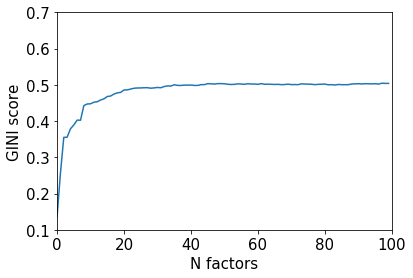

In [218]:
plt.plot(list(range(len(gini_score))), gini_score)
plt.axis([0,100,0.1,0.7])
plt.xlabel('N factors')
plt.ylabel('GINI score')
plt.show()

In [219]:
i, = np.where(gini_score == max(gini_score)) 
print('Best gini score: {:.4f} on step {}'. format(max(gini_score), int(i)))

Best gini score: 0.5044 on step 97


In [222]:
len(split_shap_features)

100

In [224]:
split_shap_features = split_shap_features[:50]
split_shap_features

['crd_cc_tot_otb_rub_amt',
 'seg_crd_segm_special_cd',
 'sd_age_yrs_frac_nv',
 'sd_age_mnth_comp_nv',
 'lbt_acct_tot_davg_qrt_rub_amt',
 'lbt_acct_tot_bal_prev_rub_amt',
 'lbt_inc_avg_risk_rub_amt',
 'sd_age_yrs_comp_nv',
 'prd_lst_prod_tb_name',
 'crd_otf_trnf_org_rub_amt',
 'lbt_payroll_avg_risk_rub_amt',
 'prd_city_lst_prod',
 'crd_pos_groceries_rub_3m_amt',
 'crd_trx_dc_pos_rtrn_6m_amt',
 'crd_trx_dc_cash_6m_qty',
 'cmpn_seg_client_ret_segment_cd',
 'crd_cc_open_qty',
 'cred_mnth_lst_pl_open_qty',
 'lbt_payroll_avg12_risk_rub_amt',
 'prd_1st_prod_tb_name',
 'cred_init_tot_rub_amt',
 'cred_cred_hist_good_nflag',
 'lbt_acct_dep_tot_bal_rub_amt',
 'sd_name_age_segment2_cd',
 'crd_txn_spnd_3m_amt',
 'crd_trx_dc_cash_3m_qty',
 'lbt_lst_payroll_agrmnt_id',
 'pnl_oi_ca_amt',
 'crd_otf_cash_sb_rub_amt',
 'lbt_acct_tot_bal_rub_amt',
 'cred_init_cc_rub_amt',
 'crd_pos_eat_out_rub_3m_amt',
 'cred_cred_hist_cd',
 'crd_dc_mnth_snc_open_qty',
 'dep_topup_12m_avg_rub_amt',
 'srv_mb_tot_qty',
 'prd_mnth_1st_prod_open_qty',
 'srv_mb_dc_act_qty',
 'crd_dc_pos_dept_stores_rub_amt',
 'lbt_acct_tot_davg_mnth_rub_amt',
 'srv_sbol_mnth_web_lst_log_qty',
 'crd_trx_dc_cash_3m_amt',
 'prd_mnth_lst_prod_open_qty',
 'lbt_inf_intr_cap_rub_amt',
 'cred_cred_hist_bad_nflag',
 'seg_prd_mb_own_avail_nflag',
 'cla_all_active_nflag',
 'crd_otf_fee_rub_amt',
 'srv_ap_utl_nflag',
 'crd_dc_lst_bal_rub_amt']

### Find Optimal cut-off selection 

22 17


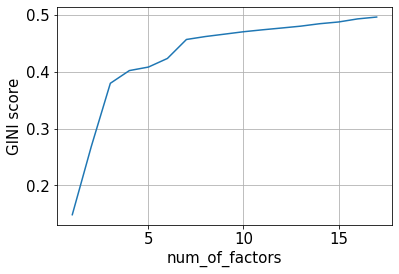

0:	learn: 0.6907576	total: 27.2ms	remaining: 21.8s
100:	learn: 0.6122770	total: 1.39s	remaining: 9.59s
200:	learn: 0.5952684	total: 2.56s	remaining: 7.62s
300:	learn: 0.5870712	total: 3.57s	remaining: 5.91s
400:	learn: 0.5815825	total: 4.74s	remaining: 4.72s
500:	learn: 0.5765901	total: 5.76s	remaining: 3.44s
600:	learn: 0.5717768	total: 6.98s	remaining: 2.31s
700:	learn: 0.5671014	total: 7.94s	remaining: 1.12s
799:	learn: 0.5625960	total: 8.97s	remaining: 0us
0:	learn: 0.6906698	total: 32.1ms	remaining: 25.7s
100:	learn: 0.6101368	total: 1.19s	remaining: 8.22s
200:	learn: 0.5929451	total: 2.15s	remaining: 6.39s
300:	learn: 0.5845549	total: 3.27s	remaining: 5.43s
400:	learn: 0.5791043	total: 4.29s	remaining: 4.27s
500:	learn: 0.5743756	total: 5.27s	remaining: 3.15s
600:	learn: 0.5691698	total: 6.48s	remaining: 2.15s
700:	learn: 0.5645287	total: 7.53s	remaining: 1.06s
799:	learn: 0.5604488	total: 8.52s	remaining: 0us
0:	learn: 0.6909868	total: 26.9ms	remaining: 21.5s
100:	learn: 0.61256

700:	learn: 0.5683242	total: 8.23s	remaining: 1.16s
799:	learn: 0.5643060	total: 9.3s	remaining: 0us
0:	learn: 0.6907576	total: 12.4ms	remaining: 9.93s
100:	learn: 0.6128453	total: 1.26s	remaining: 8.71s
200:	learn: 0.5959745	total: 2.34s	remaining: 6.99s
300:	learn: 0.5877397	total: 3.38s	remaining: 5.61s
400:	learn: 0.5818794	total: 4.44s	remaining: 4.42s
500:	learn: 0.5773974	total: 5.73s	remaining: 3.42s
600:	learn: 0.5725696	total: 7s	remaining: 2.32s
700:	learn: 0.5677833	total: 8.2s	remaining: 1.16s
799:	learn: 0.5634589	total: 9.56s	remaining: 0us
0:	learn: 0.6906698	total: 15.6ms	remaining: 12.5s
100:	learn: 0.6106208	total: 1.02s	remaining: 7.04s
200:	learn: 0.5936915	total: 2s	remaining: 5.96s
300:	learn: 0.5853795	total: 3.04s	remaining: 5.05s
400:	learn: 0.5798791	total: 3.99s	remaining: 3.97s
500:	learn: 0.5751756	total: 5.02s	remaining: 3s
600:	learn: 0.5701753	total: 6.08s	remaining: 2.02s
700:	learn: 0.5652200	total: 7.15s	remaining: 1.01s
799:	learn: 0.5610306	total: 

500:	learn: 0.5785224	total: 5.02s	remaining: 3s
600:	learn: 0.5734432	total: 5.93s	remaining: 1.96s
700:	learn: 0.5685139	total: 6.98s	remaining: 986ms
799:	learn: 0.5642993	total: 7.98s	remaining: 0us
0:	learn: 0.6907576	total: 12.7ms	remaining: 10.2s
100:	learn: 0.6126976	total: 1.03s	remaining: 7.1s
200:	learn: 0.5960088	total: 2.06s	remaining: 6.16s
300:	learn: 0.5874806	total: 3.03s	remaining: 5.02s
400:	learn: 0.5815854	total: 3.89s	remaining: 3.87s
500:	learn: 0.5770017	total: 4.81s	remaining: 2.87s
600:	learn: 0.5720179	total: 5.8s	remaining: 1.92s
700:	learn: 0.5669904	total: 6.75s	remaining: 954ms
799:	learn: 0.5626312	total: 7.84s	remaining: 0us
0:	learn: 0.6906698	total: 21.6ms	remaining: 17.3s
100:	learn: 0.6102863	total: 873ms	remaining: 6.04s
200:	learn: 0.5931755	total: 1.8s	remaining: 5.36s
300:	learn: 0.5848062	total: 2.84s	remaining: 4.71s
400:	learn: 0.5787434	total: 4.06s	remaining: 4.04s
500:	learn: 0.5742403	total: 5.19s	remaining: 3.1s
600:	learn: 0.5693879	tot

300:	learn: 0.5885531	total: 4.06s	remaining: 6.74s
400:	learn: 0.5832511	total: 5.48s	remaining: 5.45s
500:	learn: 0.5789460	total: 6.72s	remaining: 4.01s
600:	learn: 0.5742218	total: 7.83s	remaining: 2.59s
700:	learn: 0.5693860	total: 9.04s	remaining: 1.28s
799:	learn: 0.5652892	total: 10.1s	remaining: 0us
0:	learn: 0.6907576	total: 36.8ms	remaining: 29.4s
100:	learn: 0.6125779	total: 1.24s	remaining: 8.59s
200:	learn: 0.5960921	total: 2.32s	remaining: 6.92s
300:	learn: 0.5878676	total: 3.39s	remaining: 5.62s
400:	learn: 0.5823199	total: 4.35s	remaining: 4.33s
500:	learn: 0.5778390	total: 5.39s	remaining: 3.22s
600:	learn: 0.5728013	total: 6.7s	remaining: 2.22s
700:	learn: 0.5678956	total: 7.73s	remaining: 1.09s
799:	learn: 0.5636920	total: 9.01s	remaining: 0us
0:	learn: 0.6906698	total: 20.8ms	remaining: 16.6s
100:	learn: 0.6104214	total: 1.07s	remaining: 7.43s
200:	learn: 0.5933310	total: 2.14s	remaining: 6.39s
300:	learn: 0.5851202	total: 3.29s	remaining: 5.45s
400:	learn: 0.57935

100:	learn: 0.6125759	total: 1.05s	remaining: 7.28s
200:	learn: 0.5960683	total: 2.03s	remaining: 6.06s
300:	learn: 0.5881606	total: 2.99s	remaining: 4.96s
400:	learn: 0.5828540	total: 4.09s	remaining: 4.08s
500:	learn: 0.5786289	total: 4.97s	remaining: 2.96s
600:	learn: 0.5738617	total: 5.93s	remaining: 1.96s
700:	learn: 0.5690695	total: 6.99s	remaining: 987ms
799:	learn: 0.5649668	total: 8.06s	remaining: 0us
0:	learn: 0.6907576	total: 16.1ms	remaining: 12.9s
100:	learn: 0.6129515	total: 1.07s	remaining: 7.4s
200:	learn: 0.5961659	total: 2.4s	remaining: 7.17s
300:	learn: 0.5875389	total: 3.58s	remaining: 5.93s
400:	learn: 0.5817976	total: 4.71s	remaining: 4.68s
500:	learn: 0.5773106	total: 5.8s	remaining: 3.46s
600:	learn: 0.5726335	total: 6.75s	remaining: 2.24s
700:	learn: 0.5679282	total: 7.86s	remaining: 1.11s
799:	learn: 0.5637616	total: 8.84s	remaining: 0us
0:	learn: 0.6906698	total: 31.8ms	remaining: 25.4s
100:	learn: 0.6106692	total: 1.11s	remaining: 7.67s
200:	learn: 0.5936196

In [225]:
from sklearn.model_selection import cross_val_score
from IPython.display import clear_output
from sklearn.model_selection import RandomizedSearchCV, KFold

N = 50
scores = []
res_train, res_test = [], []
var_list = []

for i in range(0, N):
    var_list.append(split_shap_features[i])
    clf = CatBoostClassifier(iterations=800,
                         learning_rate= 0.021, #0.16626664163923466,
                         depth=4,
                         scale_pos_weight=10,
                         l2_leaf_reg = 9.922430597641636,
                         custom_loss=['AUC'],
                         random_seed=802,
                         bagging_temperature = 0.2,
#                        od_type='Iter',
                         metric_period=100,
#                         od_wait=100,
                         early_stopping_rounds=50
                             )
    kf = KFold(n_splits=3, shuffle=True, random_state=13)
    score = 2 * cross_val_score(clf, X=X_train[var_list], y=y_train, scoring='roc_auc', cv=kf).mean() - 1
    inc = 0.003
    if len(scores) == 0 or score > scores[-1] + inc * (inc > 0):
        scores.append(score)
    
        clf.fit(X_train[var_list], y_train)
        res_train.append(-1+2*roc_auc_score(y_train, clf.predict_proba(X_train[var_list])[:,1]))
        res_test.append(-1+2*roc_auc_score(y_test, clf.predict_proba(X_test[var_list])[:,1]))
        clear_output()
        print(i + 1, len(scores))
        plt.plot(range(1, len(scores) + 1), scores)
        plt.xlabel('num_of_factors')
        plt.ylabel('GINI score')
        plt.grid()
        plt.show()
    else:
        var_list.pop()

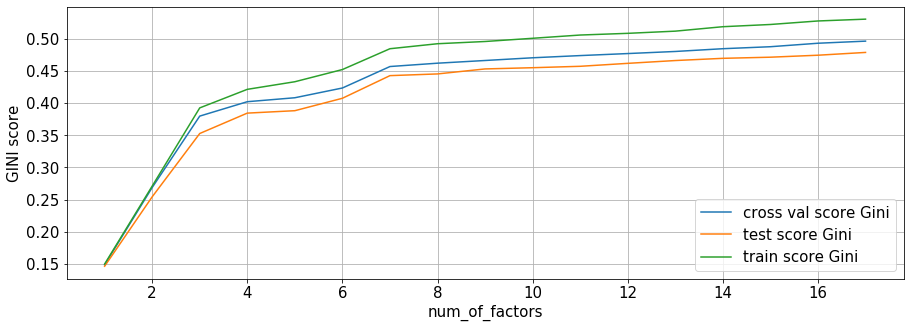

In [226]:
N = len(var_list)

plt.figure(figsize=[15,5])
plt.xlabel('num_of_factors')
plt.ylabel('GINI score')

plt.plot(range(1, N + 1), scores[:N], label='cross val score Gini')

plt.plot(range(1, N + 1), res_test[:N], label='test score Gini')
#plt.plot(range(1, N + 1), res_oot[:N], label='oot score Gini')
plt.plot(range(1, N + 1), res_train[:N], label='train score Gini')
#plt.ylim((0.5, 1))

plt.grid()
plt.legend()
plt.show()

In [227]:
res_test

[0.146370543051364,
 0.2541602165486374,
 0.3524953732479408,
 0.3841655283894343,
 0.3879293101001844,
 0.4072132392641157,
 0.44237517074158483,
 0.44502109433517334,
 0.4527792917383604,
 0.45468585163258757,
 0.4568716146012042,
 0.46144950535347373,
 0.4658157406738963,
 0.4692441834051375,
 0.47100620487845934,
 0.47408574373476386,
 0.4784088851356951]

In [228]:
var_list

['crd_cc_tot_otb_rub_amt',
 'seg_crd_segm_special_cd',
 'sd_age_yrs_frac_nv',
 'lbt_acct_tot_davg_qrt_rub_amt',
 'lbt_acct_tot_bal_prev_rub_amt',
 'lbt_inc_avg_risk_rub_amt',
 'prd_lst_prod_tb_name',
 'crd_otf_trnf_org_rub_amt',
 'prd_city_lst_prod',
 'crd_trx_dc_pos_rtrn_6m_amt',
 'crd_trx_dc_cash_6m_qty',
 'cmpn_seg_client_ret_segment_cd',
 'crd_cc_open_qty',
 'cred_mnth_lst_pl_open_qty',
 'lbt_payroll_avg12_risk_rub_amt',
 'cred_init_tot_rub_amt',
 'cred_cred_hist_good_nflag']

In [229]:
new_top_features = var_list

In [230]:
new_top_features

['crd_cc_tot_otb_rub_amt',
 'seg_crd_segm_special_cd',
 'sd_age_yrs_frac_nv',
 'lbt_acct_tot_davg_qrt_rub_amt',
 'lbt_acct_tot_bal_prev_rub_amt',
 'lbt_inc_avg_risk_rub_amt',
 'prd_lst_prod_tb_name',
 'crd_otf_trnf_org_rub_amt',
 'prd_city_lst_prod',
 'crd_trx_dc_pos_rtrn_6m_amt',
 'crd_trx_dc_cash_6m_qty',
 'cmpn_seg_client_ret_segment_cd',
 'crd_cc_open_qty',
 'cred_mnth_lst_pl_open_qty',
 'lbt_payroll_avg12_risk_rub_amt',
 'cred_init_tot_rub_amt',
 'cred_cred_hist_good_nflag']

# Final model fit with selected features

In [231]:
categorical_feature = []

for i in new_top_features:
    if i in object_feature: 
        categorical_feature = np.append(categorical_feature, i)

In [232]:
categorical_feature

array(['seg_crd_segm_special_cd', 'prd_lst_prod_tb_name',
       'prd_city_lst_prod', 'cmpn_seg_client_ret_segment_cd'],
      dtype='<U32')

In [323]:
catBoost = CatBoostClassifier(iterations=800,
                         learning_rate=0.021,
                         depth=4,
                         scale_pos_weight=10,
                         l2_leaf_reg =  9.922430597641636,
                         custom_loss=['AUC'],
                         random_seed=802,
                         bagging_temperature = 0.2,
#                         od_type='Iter',
                         metric_period=100,
#                         od_wait=100,
                         early_stopping_rounds=50    
                             )

catBoost.fit(X_train[new_top_features],y_train, cat_features=categorical_feature)

0:	learn: 0.6905733	total: 20.6ms	remaining: 16.5s
100:	learn: 0.6125236	total: 1.89s	remaining: 13.1s
200:	learn: 0.5963075	total: 3.75s	remaining: 11.2s
300:	learn: 0.5883701	total: 5.63s	remaining: 9.34s
400:	learn: 0.5837825	total: 7.46s	remaining: 7.42s
500:	learn: 0.5803758	total: 9.22s	remaining: 5.5s
600:	learn: 0.5769034	total: 11s	remaining: 3.65s
700:	learn: 0.5731665	total: 12.8s	remaining: 1.8s
799:	learn: 0.5701230	total: 14.5s	remaining: 0us


In [324]:
print('Gini Train: {0}'.format(round(-1+2*roc_auc_score(y_train, catBoost.predict_proba(X_train[new_top_features])[:,1]),4))) 
print('Gini Out-of-Sample: {0}'.format(round(-1+2*roc_auc_score(y_test, catBoost.predict_proba(X_test[new_top_features])[:,1]),4)))
print('Gini OOT: {0}'.format(round(-1+2*roc_auc_score(y_oot, catBoost.predict_proba(X_oot[new_top_features])[:,1]),4)))

Gini Train: 0.5286
Gini Out-of-Sample: 0.4806
Gini OOT: 0.4815


In [ ]:
Gini Train: 0.5286
Gini Out-of-Sample: 0.4806
Gini OOT: 0.4815

# 5. HyperOpt Optimization <a name="p5"></a>

In [235]:
import hyperopt
from hyperopt import hp, tpe, STATUS_OK, Trials
import catboost as cb
import catboost.datasets as cbd
import catboost.utils as cbu

In [236]:
def objective(space):
    clf_opt = CatBoostClassifier(learning_rate = space['learning_rate'],
                                 depth = space['depth'],
                                 l2_leaf_reg = space['l2_leaf_reg'],
                                 #scale_pos_weight = space['scale_pos_weight'],
                                 #bagging_temperature = space['bagging_temperature'],
                                                                )

In [237]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg'],
             #'scale_pos_weight': hyper_params['scale_pos_weight']
            #'bagging_temperature': hyper_params['bagging_temperature'],
          
        }
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()
        
        # we use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=4242,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        max_mean_auc = np.max(scores['test-AUC-mean']) # change 'max' on 'avg'
        print('evaluated score={}'.format(max_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -max_mean_auc, 'status': hyperopt.STATUS_OK}

In [238]:
def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.01, 0.5),
        'depth': hyperopt.hp.randint('depth',10),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10),
        #'scale_pos_weight': hyperopt.hp.uniform('scale_pos_weight', 1, 20)
        #'bagging_temperature': hyperopt.hp.uniform('bagging_temperature', 0.1, 0.5),
        #'iterations': hyperopt.hp.randint('iterations', 1000)
    }
    
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=2)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=4242))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != np.float)[0])
    
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.1, 
            'depth': 6, 
            'l2_leaf_reg': 1,
           #'scale_pos_weight': 8
            'bagging_temperature': 0.2,
            #'iterations': 1000
        }
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [239]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 30

const_params = dict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 100,
    'random_seed': 802})

model, params = train_best_model(
    X_train[new_top_features], y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)

evaluating params={'learning_rate': 0.04835038563978181, 'depth': 5, 'l2_leaf_reg': 2.9748991484030154, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 802}
evaluated score=0.735629018776892                   
evaluated 1 times                                   
evaluating params={'learning_rate': 0.24494855927037054, 'depth': 8, 'l2_leaf_reg': 9.629585619079913, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 802}
evaluated score=0.7396225131044243                                           
evaluated 2 times                                                            
evaluating params={'learning_rate': 0.29999839277110985, 'depth': 7, 'l2_leaf_reg': 2.384213936358041, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 802}
evaluated score=0.73726

In [117]:
params

{'custom_metric': ['AUC'],
 'depth': 4,
 'eval_metric': 'AUC',
 'iterations': 100,
 'l2_leaf_reg': 9.922430597641636,
 'learning_rate': 0.16626664163923466,
 'loss_function': 'Logloss',
 'random_seed': 802,
 'task_type': 'CPU'}

In [240]:
categorical_feature = []

for i in new_top_features:
    if i in object_feature: 
        categorical_feature = np.append(categorical_feature, i)

In [241]:

clf_top = CatBoostClassifier(iterations=800,
                         learning_rate=0.021,
                         depth=4,
                         scale_pos_weight=10,
                         l2_leaf_reg =  9.922430597641636,
                         custom_loss=['AUC'],
                         random_seed=802,
                         bagging_temperature = 0.2,
#                         od_type='Iter',
                         metric_period=100,
#                         od_wait=100,
                         early_stopping_rounds=50    
                             )

In [242]:
len(new_top_features)

17

In [243]:
clf_top.fit(X_train[new_top_features],y_train, cat_features=categorical_feature, verbose=False)

In [244]:
print('Gini Train: {0}'.format(round(-1+2*roc_auc_score(y_train, clf_top.predict_proba(X_train[new_top_features])[:,1]),4))) 
print('Gini Test: {0}'.format(round(-1+2*roc_auc_score(y_test, clf_top.predict_proba(X_test[new_top_features])[:,1]),4)))
print('Gini OOT: {0}'.format(round(-1+2*roc_auc_score(y_oot, clf_top.predict_proba(X_oot[new_top_features])[:,1]),4)))

Gini Train: 0.5286
Gini Test: 0.4806
Gini OOT: 0.4815


In [245]:
pkl_filename_ = "catboost_lifeins_cc_top.pkl"
with open (pkl_filename_, 'wb') as file:
    pickle.dump(clf_top, file)

# 6. Model calibration <a name="p6"></a>

In [246]:
from sklearn.isotonic import IsotonicRegression as IR

#  Out-of-Time scores Calibration
no_calibr = clf_top.predict_proba(X_oot[new_top_features])[:,1]

ir = IR(out_of_bounds='clip')
ir.fit(no_calibr, y_oot)

calibr = ir.transform(no_calibr)

d = {'target': y_oot,'no_calib_score': no_calibr, 'calib_score': calibr}
scores = pd.DataFrame(d)

In [247]:
scores.head()

,target,no_calib_score,calib_score
0,0,0.158332,0.006601
1,0,0.180460,0.009901
3,1,0.471624,0.101609
4,0,0.491358,0.101609
8,0,0.440287,0.073442


In [267]:
y_oot.value_counts(normalize=True)

0    0.911038
1    0.088962
Name: target, dtype: float64

In [268]:
scores['no_calib_score'].mean()

0.4176380100715565

In [269]:
scores['calib_score'].mean()

0.088962284253143

In [270]:
# Save our trained CALIBRATED model 
pkl_filename = "LIFEINS_CC_TOP17_var_CALIB.pkl"
with open (pkl_filename, 'wb') as file:
    pickle.dump(ir,file)

In [309]:
 pred = ir.transform(clf_top.predict_proba(X_oot[new_top_features])[:,1])

In [311]:
len(pred)

28158

# 7. Model Report <a name="p7"></a>

In [292]:
import xlsxwriter
import datetime
import os

import sys
import xlrd

In [293]:
d = {'Variable': X_train[new_top_features].columns.tolist()}
df_discr = pd.DataFrame(d)
df_discr['Description'] = np.nan
df_discr

,Variable,Description
0,crd_cc_tot_otb_rub_amt,NaN
1,seg_crd_segm_special_cd,NaN
2,sd_age_yrs_frac_nv,NaN
3,lbt_acct_tot_davg_qrt_rub_amt,NaN
4,lbt_acct_tot_bal_prev_rub_amt,NaN
5,lbt_inc_avg_risk_rub_amt,NaN
6,prd_lst_prod_tb_name,NaN
7,crd_otf_trnf_org_rub_amt,NaN
8,prd_city_lst_prod,NaN
9,crd_trx_dc_pos_rtrn_6m_amt,NaN


In [294]:
x_tr, x_tst, y_tr, y_tst = train_test_split(X_train[df_discr['Variable'].to_list()], y_train, test_size = 0.3, random_state=0)

In [295]:
path = 'Report.xlsx'
if os.path.exists(path):
    os.remove(path)
writer = pd.ExcelWriter(path, engine='xlsxwriter')

In [296]:
# IV Calculation for features (array)

n_bins = 20
def iv_calc(x, y, bins=n_bins):
    if x.dtypes != 'object':
        df_for_iv = pd.DataFrame({'X': x, 'Y' : y})
        df_counts = pd.DataFrame({'bin': list(range(n_bins+1))})
        df_for_iv['bin'] = pd.qcut(df_for_iv.X.rank(method='first'), q=n_bins, labels=list(range(n_bins)))
        df_for_iv['bin']=df_for_iv['bin'].apply(lambda x: x+1)
        df_counts = pd.merge(df_counts, df_for_iv.groupby(by='bin', axis=0).count().Y, left_index=True, right_index=True, how='left')
        df_counts = pd.merge(df_counts, df_for_iv[df_for_iv['Y']==1].groupby(by='bin', axis=0).count().Y, left_index=True, right_index=True, how='left')
        df_counts = pd.merge(df_counts, df_for_iv[df_for_iv['Y']==0].groupby(by='bin', axis=0).count().Y, left_index=True, right_index=True, how='left')
        df_counts.columns = ['N bin', 'Count', '#Event', '#Non Event']
        df_counts[['Count', '#Event', '#Non Event']] = df_counts[['Count', '#Event', '#Non Event']].fillna(0)
        df_counts["%Event"] = df_counts['#Event']/df_for_iv[df_for_iv.Y==1].shape[0]
        df_counts["%Non Event"] = df_counts['#Non Event']/df_for_iv[df_for_iv.Y==0].shape[0]
        if (df_counts[df_counts["%Event"]==0].shape[0] != 0):
            df_counts[df_counts["%Event"]==0] = df_counts[df_counts["%Event"]==0].apply(lambda x: x + 0.001)
        if (df_counts[df_counts["%Non Event"]==0].shape[0] != 0):
            df_counts[df_counts["%Non Event"]==0] = df_counts[df_counts["%Non Event"]==0].apply(lambda x: x + 0.001)
        df_counts["WOE"] = np.log(df_counts["%Event"]/df_counts["%Non Event"])
        df_counts["%Event - %Non Event"] = df_counts["%Event"] - df_counts["%Non Event"]
        df_counts["IV"] = df_counts["%Event - %Non Event"]*df_counts["WOE"]
        IV_sum = round(df_counts.IV.sum(), 4)
    else:
        print('OBJECT')
    return IV_sum

In [297]:
# Recording all features and their IV metrics in xls report

def iv_sheet(x, y):

    df_iv_all = pd.DataFrame({'Variable': [], 'IV': [], 'Selected': [], 'Description': []})
    for i in list(x.columns):
        print(i)
        df_iv_var = pd.DataFrame({'Variable': [i]})
        df_iv_var['IV'] = iv_calc(x[i], y)
        if i in df_discr['Variable'].to_list():
            df_iv_var['Selected'] = 'Y'
            df_iv_var['Description'] = df_discr[df_discr['Variable']==i]['Description'].values
        else:
            df_iv_var['Selected'] = 'N'
            df_iv_var['Description'] = '-'
        df_iv_all = pd.concat([df_iv_all, df_iv_var])
    df_iv_all = df_iv_all.sort_values(by='Selected', ascending=False)
    
    # сохранение в Отчёт!
    df_iv_all.to_excel(writer, sheet_name='Variables_IV', index=False)
    df_iv_all.to_csv('Variables_IV.csv',index=False)
#    show_thms = pd.read_excel('Report.xlsx', header=0, sheet_name='Variables_IV')
#    return show_thms 

In [298]:
list_of_index_good_nan = X_train.isna().sum().sort_values().head(1500).index.to_list()

In [299]:
obj_var = X_train[list_of_index_good_nan].dtypes[X_train[list_of_index_good_nan].dtypes==object].index.to_list()
num_var = X_train[list_of_index_good_nan].drop(X_train[list_of_index_good_nan].\
                                               dtypes[X_train[list_of_index_good_nan].dtypes==object].\
                                               index.to_list(), axis=1).columns.to_list()

In [300]:
iv_sheet(X_train[obj_var+num_var], y_train)

sd_gender_cd
lne_ovd_overdue_nflag
cmpn_cb_staff_nflag
cla_all_active_nflag
prd_city_lst_prod
ext_employee_dzo
lne_tot_debt_int_ovrd_rub_amt
crd_otf_cash_atm_rub_amt
crd_otf_cash_atm_qty
lbt_payroll_avg12_risk_rub_amt
lbt_social_avg12_risk_rub_amt
lifestyle_meloman
lifestyle_learning
lifestyle_level_no_cash
lifestyle_dutyfree_qty
lifestyle_usage_value
lne_debt_overdue_bal_rub_amt
lifestyle_charity
ppc_pay_active_qty
ppc_pay_active_1m_nflag
crd_dc_active_open_qty
crd_cc_active_open_qty
lbt_social_disab_pension
ppc_crd_dc_active_1m_nflag
ppc_crd_dc_active_nflag
ppc_crd_dc_active_qty
ppc_crd_cc_active_1m_nflag
ppc_crd_cc_active_nflag
ppc_crd_cc_active_qty
ppc_mb_active_1m_nflag
ppc_mb_active_nflag
ppc_mb_active_qty
ppc_p2p_active_1m_nflag
ppc_p2p_active_nflag
ppc_p2p_active_qty
ppc_pay_active_nflag
crd_ever_nflag
bankproduct_prod_actv_cnt
lifestyle_is_investment
lifestyle_good_driver
prgnt_salary_paym_amt_rub
prgnt_other_paym_qty
prgnt_other_paym_amt_rub
lifestyle_estate_owner
opinion_lea

crd_inf_total_qty
crd_inf_dc_total_qty
crd_inf_ext_transf_rub_amt
crd_inf_ext_transf_qty
crd_inf_cash_adv_rub_amt
crd_inf_cash_adv_qty
crd_inf_transfer_rub_amt
crd_inf_transfer_qty
crd_inf_pos_ret_rub_amt
crd_inf_pos_ret_qty
crd_inf_othr_rub_amt
crd_inf_othr_qty
crd_cc_overdue_nflag
crd_dc_payroll_nflag
crd_cc_tot_credit_rub_amt
crd_cc_own_bal_rub_amt
crd_dc_payroll_act_nflag
crd_dc_social_nflag
crd_dc_social_pmt_nflag
crd_dc_social_act_nflag
crd_dc_open_qty
crd_dc_act_qty
crd_dc_act_all_qty
crd_dc_act_spend_qty
crd_cc_open_qty
crd_cc_issued_qty
crd_cc_act_qty
crd_cc_act_all_qty
crd_cc_act_spend_qty
crd_tot_act_qty
crd_tot_act_spend_qty
crd_cc_tot_os_rub_amt
lbt_acct_dep_td_bal_rub_amt
lbt_acct_dep_ca_bal_rub_amt
lbt_acct_dep_tot_bal_rub_amt
prd_cc_active_prev_nflag
prd_ma_active_nflag
prd_ma_active_qty
prd_ma_active_prev_nflag
prd_da_active_nflag
prd_da_active_qty
prd_da_active_prev_nflag
prd_sc_active_nflag
prd_sc_active_qty
prd_sc_active_prev_nflag
prd_pl_active_nflag
prd_pl_active_

In [314]:
# Creating list with performance metrics by 20 bins for Train|Validation|Out-of-Time datasets

def stats_for_predict(y_f, y_2f, x_f, x_predict_f, sheet_name):
    
    clf_best = clf_top # <-- Put in your hyper params here!!!
    #clf_best.fit(x_f, y_f)
    df_helper = pd.DataFrame({'y_score': ir.transform(clf_best.predict_proba(x_predict_f)[:,1]),
                      'y_true': y_2f})
    pred = ir.transform(clf_best.predict_proba(x_predict_f)[:,1])
    df_helper['Bin'] = pd.qcut(df_helper.y_score.rank(method='first'), q=20, labels=list(range(20)))
    df_full_st = df_helper.groupby('Bin').apply(np.max)['y_score'].rename('Prob_max')
    df_full_st = pd.merge(df_full_st, df_helper.groupby('Bin').apply(np.min)['y_score'].rename('Prob_min'),
                      how='left', left_index = True, right_index = True)
    df_full_st = pd.merge(df_full_st, df_helper.groupby('Bin').apply(np.mean)['y_score'].rename('Prob_avg'),
                      how='left', left_index = True, right_index = True)
    df_full_st = pd.merge(df_full_st, df_helper.groupby('Bin').size().rename('# obs'),
                      how='left', left_index = True, right_index = True)
    df_full_st = pd.merge(df_full_st, df_helper[df_helper['y_true']==1].groupby('Bin').size().rename('# event'),
                      how='left', left_index = True, right_index = True)
    df_full_st = pd.merge(df_full_st, df_helper[df_helper['y_true']==0].groupby('Bin').size().rename('# nonevent'),
                      how='left', left_index = True, right_index = True)
    df_full_st = pd.merge(df_full_st, (df_full_st['# event']/df_full_st['# obs']).rename('event rate'),
                      how='left', left_index = True, right_index = True)
    df_full_st.reset_index(inplace=True)
    df_full_st.sort_values(by='Bin', axis=0, ascending=False, inplace=True)
    df_full_st.set_index('Bin', inplace=True)
    df_full_st['cum_#_ev'] = df_full_st['# event'].cumsum()
    df_full_st['cum_#_nonev'] = df_full_st['# nonevent'].cumsum()
    df_full_st['1-Specificity'] = df_full_st['# nonevent'].cumsum() / df_full_st['# nonevent'].sum()
    df_full_st['Sensetivity'] = df_full_st['# event'].cumsum() / df_full_st['# event'].sum()
    temp_arr = ['-']*19
    temp_arr.append(
        str(round(-1+2*roc_auc_score(y_2f, pred), 4)))
    df_full_st['Gini'] = temp_arr
    temp_arr = ['-']*19
    temp_arr.append(
        str(round(roc_auc_score(y_2f, pred), 4)))
    df_full_st['AUC'] = temp_arr
    df_full_st['BaseLine'] = np.linspace(0,1,21)[1:]
    
    df_full_st['Prob_max'] = df_full_st['Prob_max'].apply(lambda x: '{:.2%}'.format(x))
    df_full_st['Prob_min'] = df_full_st['Prob_min'].apply(lambda x: '{:.2%}'.format(x))
    df_full_st['Prob_avg'] = df_full_st['Prob_avg'].apply(lambda x: '{:.2%}'.format(x))
    df_full_st['event rate'] = df_full_st['event rate'].apply(lambda x: '{:.2%}'.format(x))
    df_full_st['1-Specificity'] = df_full_st['1-Specificity'].apply(lambda x: '{:.2%}'.format(x))
    df_full_st['Sensetivity'] = df_full_st['Sensetivity'].apply(lambda x: '{:.2%}'.format(x))
    df_full_st.reset_index(inplace=True)

    df_full_st.to_excel(writer, sheet_name=sheet_name, index=False)

In [315]:
# Call functions

stats_for_predict(y_train, y_train, X_train[new_top_features], X_train[new_top_features], 'KS Gini Train')
stats_for_predict(y_train, y_test, X_train[new_top_features], X_test[new_top_features], 'KS Gini Val')
stats_for_predict(y_train, y_oot, X_train[new_top_features], X_oot[new_top_features], 'KS Gini OOT')

In [316]:
writer.save()